In [2]:
!pip install arch

   ---------------------------------------- 0.0/925.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/925.2 kB ? eta -:--:--
   ---------------------------------------- 925.2/925.2 kB 6.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
df = pd.read_csv('Datasets/SPY.csv', parse_dates=True, index_col='Date')

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [6]:
df['LogRet'] = np.log(df['Close']).diff()

In [7]:
# df2 = df.loc['2010-01-05':'2015-01-01'].copy()
df2 = df.iloc[1:].copy()

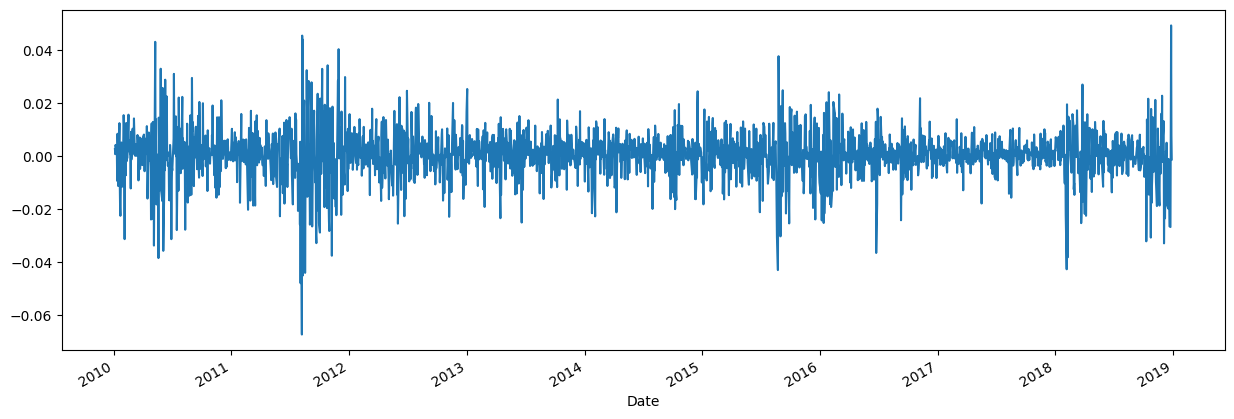

In [8]:
df2['LogRet'].plot(figsize=(15, 5));

In [9]:
df2['Ysq'] = df['LogRet'] ** 2

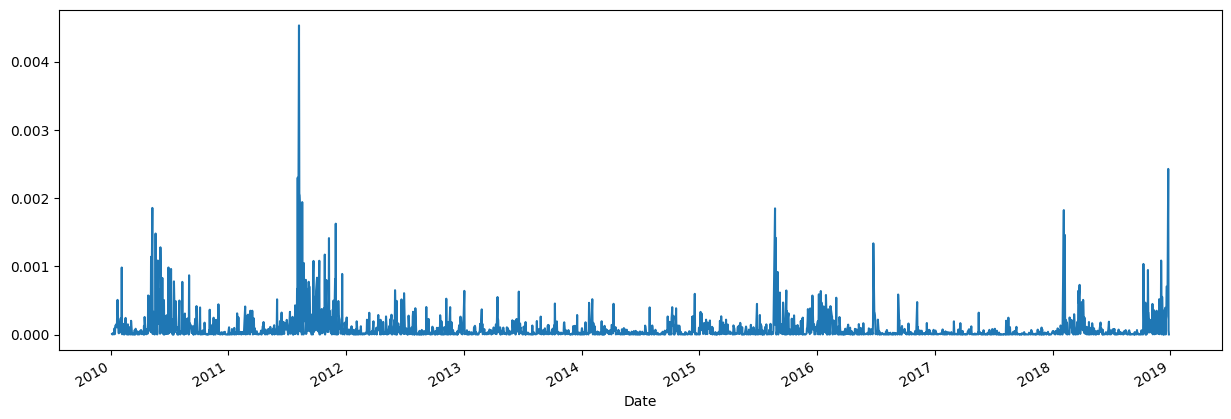

In [10]:
df2['Ysq'].plot(figsize=(15, 5));

## ACF and PACF

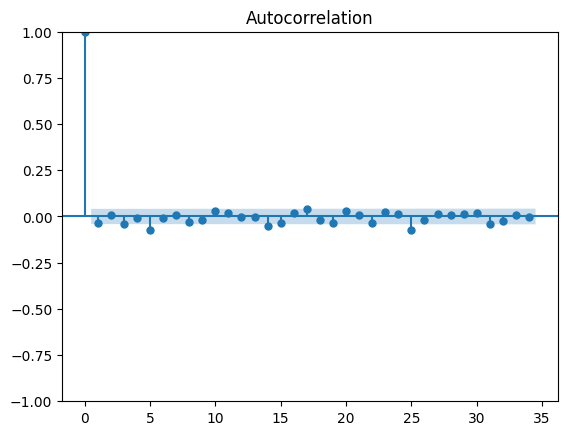

In [11]:
plot_acf(df2['LogRet']);

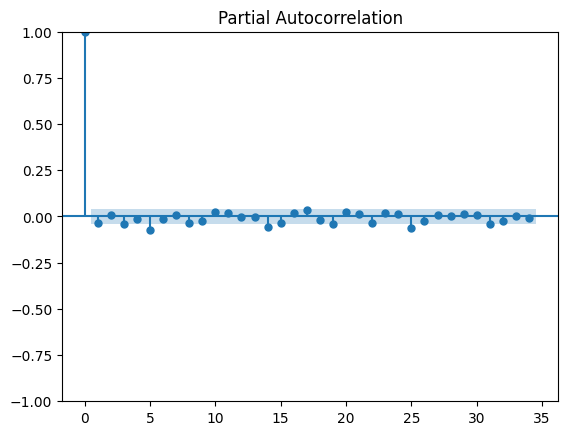

In [12]:
plot_pacf(df2['LogRet']);

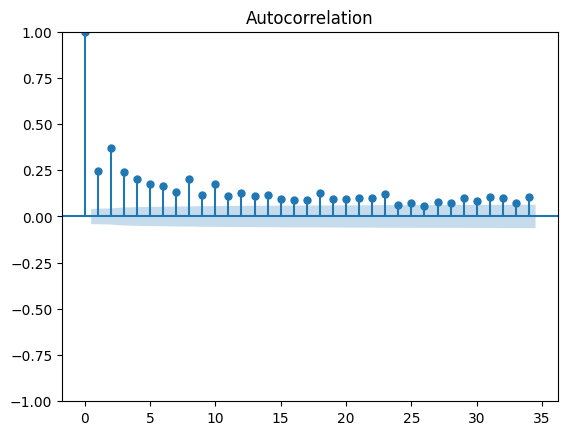

In [13]:
plot_acf(df2['Ysq']);

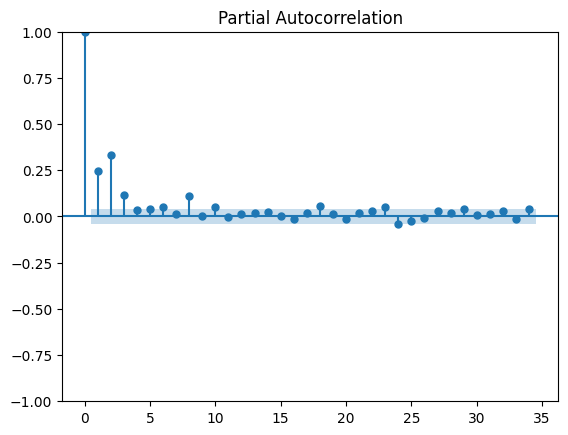

In [14]:
plot_pacf(df2['Ysq']);

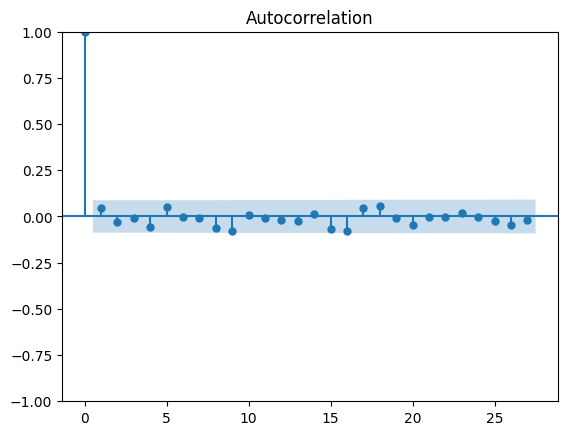

In [15]:
noise_sq = np.random.randn(500)**2
plot_acf(noise_sq);

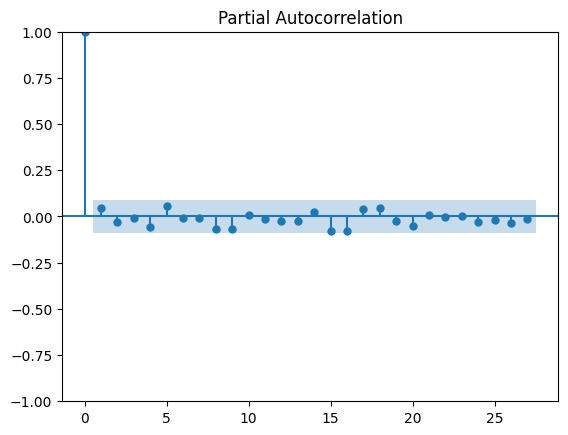

In [16]:
plot_pacf(noise_sq);

## Train-Test Split

In [17]:
Ntest = 500
train = df2.iloc[:-Ntest][['LogRet']].copy()
test = df2.iloc[-Ntest:][['LogRet']].copy()

## Why Do We Need Scaling?

In [18]:
model = arch_model(train['LogRet'], vol='GARCH', p=1, q=1)

In [19]:
res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2668736234320.3926
Iteration:      2,   Func. Count:     19,   Neg. LLF: 681495796603480.9
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2099329788588.272
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1148800069593708.8
Iteration:      5,   Func. Count:     62,   Neg. LLF: 20672973870.71515
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.0138966357037168e+16
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1121326932594.181
Iteration:      8,   Func. Count:    103,   Neg. LLF: 207123748884025.1
Iteration:      9,   Func. Count:    118,   Neg. LLF: 14017524989.133617
Iteration:     10,   Func. Count:    131,   Neg. LLF: 275892953358924.4
Iteration:     11,   Func. Count:    145,   Neg. LLF: -5876.685308750586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5876.68531086581
            Iterations: 15
            Function evaluations: 145
            Gradient evalu

C:\Users\ADMIN\anaconda3\envs\Tensorflow_GPU\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.532e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## ARCH(1)

In [20]:
m = train['LogRet'].mean()
s = train['LogRet'].std()
train['Scaled'] = (train['LogRet'] - m) / s
test['Scaled'] = (test['LogRet'] - m) / s
df2['Scaled'] = (df2['LogRet'] - m) / s

In [21]:
arch1 = arch_model(train['Scaled'], vol='ARCH', p=1)

In [22]:
res_arch1 = arch1.fit(update_freq=10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2457.984028831199
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6


In [23]:
res_arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2457.98
Distribution:                  Normal   AIC:                           4921.97
Method:            Maximum Likelihood   BIC:                           4938.39
                                        No. Observations:                 1762
Date:                Sun, Sep 22 2024   Df Residuals:                     1761
Time:                        17:06:47   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0127  2.325e-02      0.545      0.586 [-3.291e-02,5.825e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.8188  6.722e-02     12.181  3.936e-34   [  0.687,  0.951]
alpha[1]       0.1771  4.774e-02      3.709  2.079e-04 [8.350e-02,  0.271]
==========================================================================

Covariance estimator: robust
"""

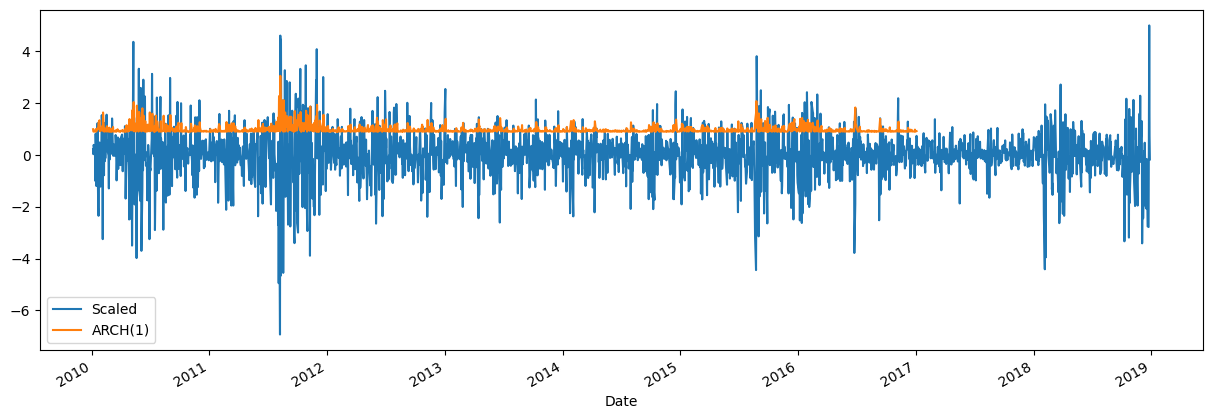

In [24]:
df2['ARCH(1)'] = res_arch1.conditional_volatility
df2[['Scaled', 'ARCH(1)']].plot(figsize=(15, 5));

In [25]:
res_arch1.forecast(horizon=Ntest)

In [26]:
fcast_arch1 = res_arch1.forecast(horizon=Ntest, reindex=True)

In [27]:
fcast_arch1

In [28]:
fcast_arch1.mean

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
fcast_arch1.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
fcast_arch1.residual_variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
fcast_arch1 = res_arch1.forecast(horizon=Ntest, reindex=False)

In [32]:
fcast_arch1.mean

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,...,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671,0.012671


In [33]:
fcast_arch1.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.912612,0.98042,0.992427,0.994553,0.994929,0.994996,0.995008,0.99501,0.99501,0.99501,...,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501


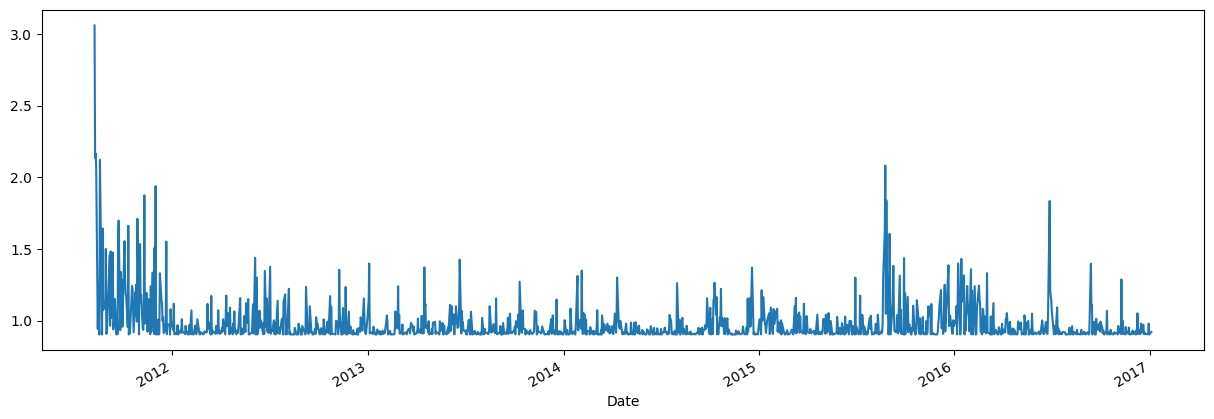

In [34]:
df2.loc['2011-08-09':]['ARCH(1)'].plot(figsize=(15, 5));

In [35]:
fcast_arch1 = res_arch1.forecast(
    horizon=Ntest, reindex=True, start='2011-08-01')

In [36]:
fcast_arch1.variance['2011-07-28':'2011-08-05']

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,0.861165,0.971311,0.990814,0.994267,0.994879,0.994987,0.995006,0.995009,0.995010,0.995010,...,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501
2011-08-02,2.112095,1.192807,1.030033,1.001211,0.996108,0.995205,0.995045,0.995016,0.995011,0.995010,...,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501
2011-08-03,0.863233,0.971677,0.990879,0.994279,0.994881,0.994987,0.995006,0.995009,0.995010,0.995010,...,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501
2011-08-04,5.183712,1.736683,1.126334,1.018263,0.999127,0.995739,0.995139,0.995033,0.995014,0.995011,...,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501
2011-08-05,0.826340,0.965145,0.989722,0.994074,0.994844,0.994981,0.995005,0.995009,0.995010,0.995010,...,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501,0.99501


In [37]:
fcast_arch1.variance.loc['2011-08-09'].to_numpy().shape

(500,)

In [38]:
df2.index.get_loc('2011-08-09')

402

In [39]:
df2.index[402 + 500]

Timestamp('2013-08-06 00:00:00')

In [40]:
df2.loc['2011-08-10':'2013-08-06', 'ARCH(1) Forecast'] = np.sqrt(
    fcast_arch1.variance.loc['2011-08-09'].to_numpy())

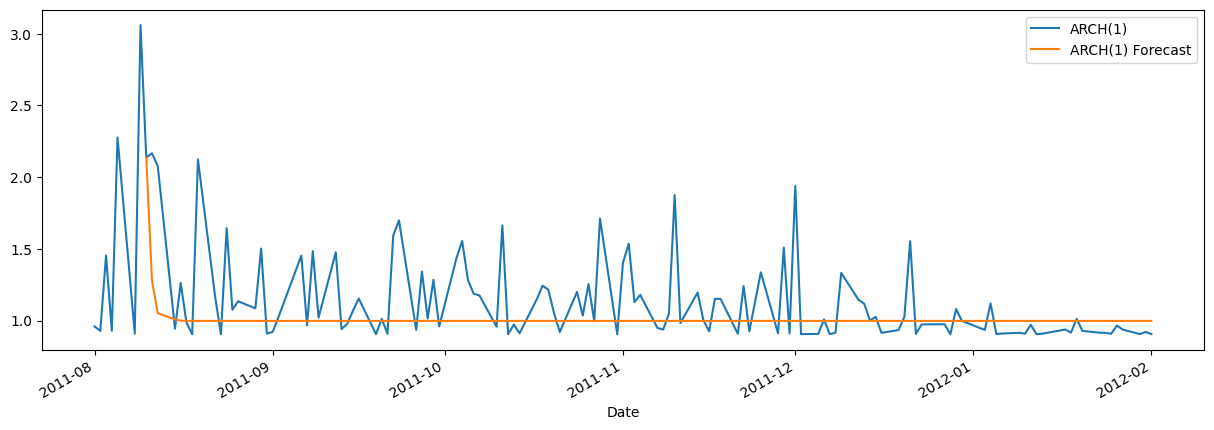

In [41]:
df2.loc['2011-08-01':'2012-02-01'][['ARCH(1)', 'ARCH(1) Forecast']].plot(
    figsize=(15, 5));

In [42]:
fcast_arch1.variance.index.get_loc('2011-08-17')

408

In [43]:
df2.index[408 + 500]

Timestamp('2013-08-14 00:00:00')

In [44]:
df2.loc['2011-08-18':'2013-08-14', 'ARCH(1) Forecast Low'] = np.sqrt(
    fcast_arch1.variance.loc['2011-08-17'].to_numpy())

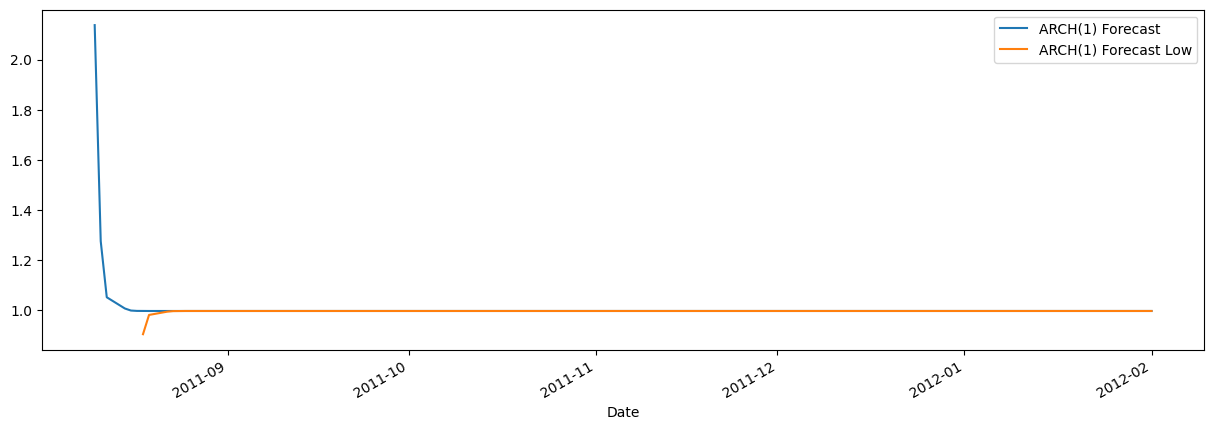

In [45]:
plot_cols = ['ARCH(1) Forecast', 'ARCH(1) Forecast Low']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15, 5));

In [46]:
# theoretical unconditional variance
res_arch1.params

mu          0.012671
omega       0.818829
alpha[1]    0.177065
Name: params, dtype: float64

In [47]:
res_arch1.params['omega'] / (1 - res_arch1.params['alpha[1]'])

0.99501008483029

In [48]:
fcast_arch1.variance.loc['2011-08-17'].to_numpy()[-1]

0.9950100848302899

In [49]:
fcast_arch1.variance.loc['2011-08-09'].to_numpy()[-1]

0.9950100848302899

## GARCH(1, 1)

In [50]:
garch11 = arch_model(train['Scaled'], vol='GARCH', p=1, q=1)

In [51]:
res_garch11 = garch11.fit(update_freq=10)

Iteration:     10,   Func. Count:     62,   Neg. LLF: 2269.107952001976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2269.107941826097
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


In [52]:
res_garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2269.11
Distribution:                  Normal   AIC:                           4546.22
Method:            Maximum Likelihood   BIC:                           4568.11
                                        No. Observations:                 1762
Date:                Sun, Sep 22 2024   Df Residuals:                     1761
Time:                        17:09:11   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0287  1.865e-02      1.538      0.124 [-7.863e-03,6.525e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0469  1.060e-02      4.427  9.560e-06 [2.615e-02,6.770e-02]
alpha[1]       0.1499  2.499e-02      6.000  1.972e-09     [  0.101,  0.199]
beta[1]        0.8021  2.545e-02     31.516 5.232e-218     [  0.752,  0.852]
============================================================================

Covariance estimator: robust
"""

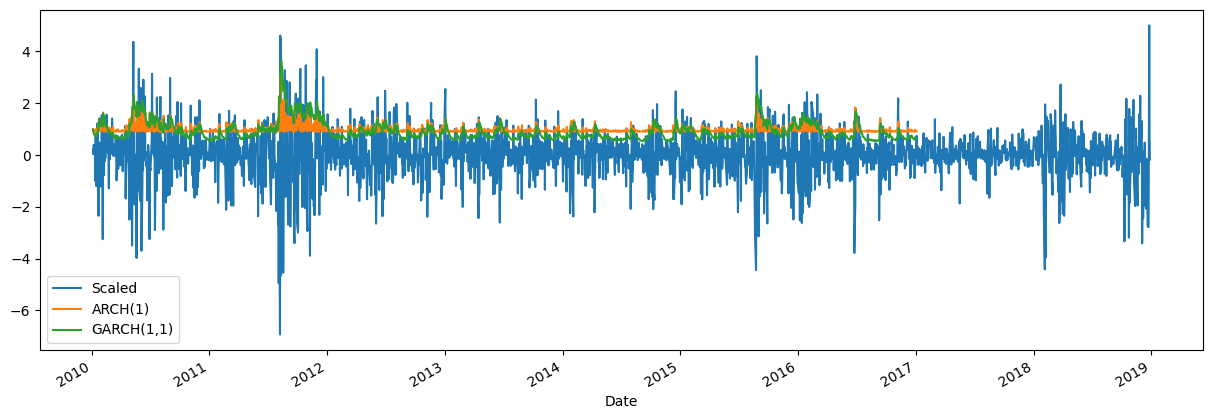

In [53]:
df2['GARCH(1,1)'] = res_garch11.conditional_volatility
df2[['Scaled', 'ARCH(1)', 'GARCH(1,1)']].plot(figsize=(15, 5));

In [54]:
fcast_garch11 = res_garch11.forecast(
    horizon=Ntest, reindex=False, start='2011-08-09')

In [55]:
df2.loc['2011-08-10':'2013-08-06', 'GARCH(1,1) Forecast'] = np.sqrt(
    fcast_garch11.residual_variance.loc['2011-08-09'].to_numpy())

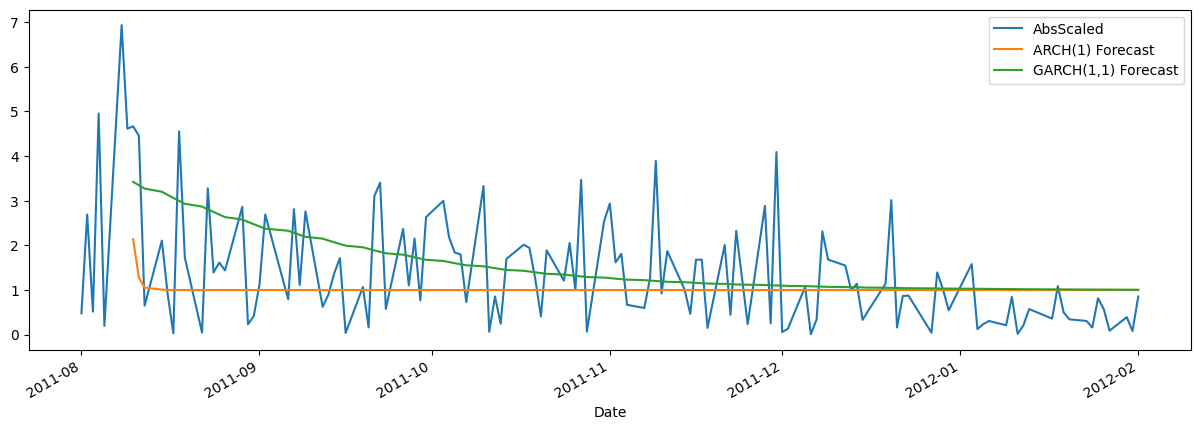

In [56]:
df2['AbsScaled'] = df2['Scaled'].abs()

plot_cols = ['AbsScaled', 'ARCH(1) Forecast', 'GARCH(1,1) Forecast']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15, 5));

## t-Distribution

In [57]:
garch11t = arch_model(train['Scaled'], vol='GARCH', p=1, q=1, dist='StudentsT')

In [58]:
res_garch11t = garch11t.fit(update_freq=10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 2230.182984797736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2230.1797865916124
            Iterations: 14
            Function evaluations: 97
            Gradient evaluations: 14


In [59]:
res_garch11t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       Scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2230.18
Distribution:      Standardized Student's t   AIC:                           4470.36
Method:                  Maximum Likelihood   BIC:                           4497.73
                                              No. Observations:                 1762
Date:                      Sun, Sep 22 2024   Df Residuals:                     1761
Time:                              17:10:02   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0471  1.691e-02      2.788  5.309e-03 [1.400e-02,8.028e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0399  9.295e-03      4.296  1.742e-05 [2.171e-02,5.815e-02]
alpha[1]       0.1615  2.507e-02      6.442  1.180e-10     [  0.112,  0.211]
beta[1]        0.8081  2.353e-02     34.350 1.428e-258     [  0.762,  0.854]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.5803      0.733      7.610  2.735e-14 [  4.143,  7.017]
========================================================================

Covariance estimator: robust
"""

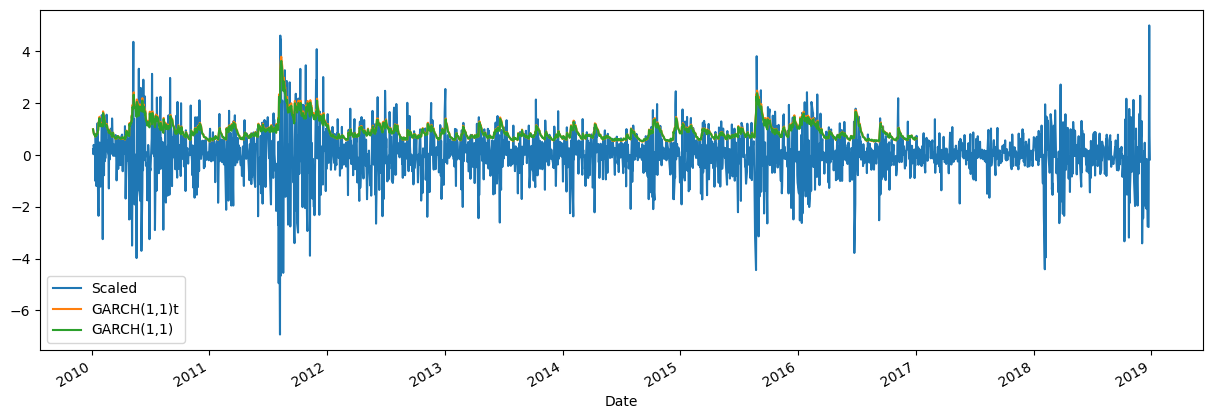

In [60]:
df2['GARCH(1,1)t'] = res_garch11t.conditional_volatility
df2[['Scaled', 'GARCH(1,1)t', 'GARCH(1,1)']].plot(figsize=(15, 5));

In [61]:
fcast_garch11t = res_garch11t.forecast(
    horizon=Ntest, reindex=False, start='2011-08-09')

In [62]:
df2.loc['2011-08-10':'2013-08-06', 'GARCH(1,1)t Forecast'] = np.sqrt(
    fcast_garch11t.residual_variance.loc['2011-08-09'].to_numpy())

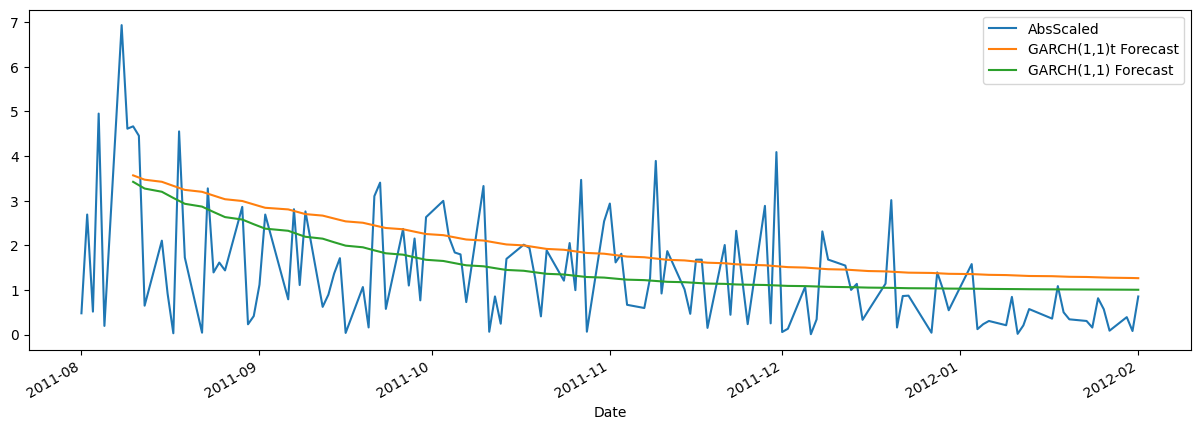

In [63]:
plot_cols = ['AbsScaled', 'GARCH(1,1)t Forecast', 'GARCH(1,1) Forecast']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15, 5));

## GARCH(p, q)

In [64]:
garchpq = arch_model(train['Scaled'], p=8, q=5, dist='StudentsT')

In [65]:
res_garchpq = garchpq.fit(update_freq=10)

Iteration:     10,   Func. Count:    186,   Neg. LLF: 2614.247604737304
Iteration:     20,   Func. Count:    369,   Neg. LLF: 2224.5185152034373
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2224.218116955094
            Iterations: 29
            Function evaluations: 522
            Gradient evaluations: 29


In [66]:
res_garchpq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       Scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2224.22
Distribution:      Standardized Student's t   AIC:                           4480.44
Method:                  Maximum Likelihood   BIC:                           4568.02
                                              No. Observations:                 1762
Date:                      Sun, Sep 22 2024   Df Residuals:                     1761
Time:                              17:10:53   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0483  1.715e-02      2.817  4.846e-03 [1.470e-02,8.192e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1008  5.518e-02      1.826  6.782e-02 [-7.381e-03,  0.209]
alpha[1]       0.0744  3.351e-02      2.220  2.643e-02  [8.710e-03,  0.140]
alpha[2]       0.1687  6.307e-02      2.675  7.481e-03  [4.508e-02,  0.292]
alpha[3]   4.4065e-14      0.108  4.069e-13      1.000    [ -0.212,  0.212]
alpha[4]       0.0116  9.810e-02      0.118      0.906    [ -0.181,  0.204]
alpha[5]       0.0370  7.045e-02      0.525      0.599    [ -0.101,  0.175]
alpha[6]       0.0277  5.507e-02      0.503      0.615 [-8.025e-02,  0.136]
alpha[7]       0.0145  6.710e-02      0.216      0.829    [ -0.117,  0.146]
alpha[8]       0.0381  5.692e-02      0.670      0.503 [-7.342e-02,  0.150]
beta[1]        0.5490      0.499      1.100      0.271    [ -0.429,  1.527]
beta[2]        0.0000      0.623      0.000      1.000    [ -1.220,  1.220]
beta[3]    6.0661e-15      0.549  1.105e-14      1.000    [ -1.076,  1.076]
beta[4]    1.3117e-14      0.354  3.708e-14      1.000    [ -0.693,  0.693]
beta[5]    8.1697e-14      0.346  2.360e-13      1.000    [ -0.678,  0.678]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.7008      0.772      7.386  1.510e-13 [  4.188,  7.214]
========================================================================

Covariance estimator: robust
"""

In [67]:
res_arch1.aic, res_garch11.aic, res_garch11t.aic, res_garchpq.aic

(4921.968057662398, 4546.215883652194, 4470.359573183225, 4480.436233910188)

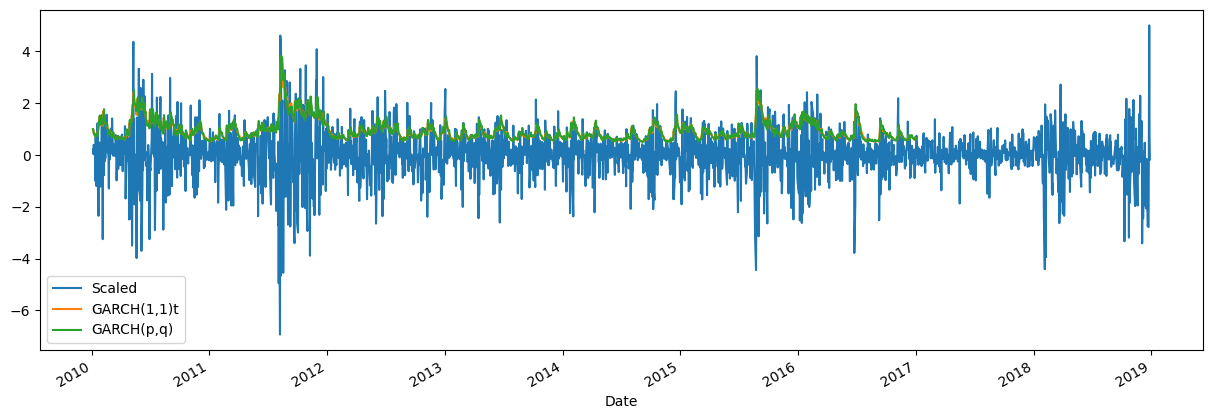

In [68]:
df2['GARCH(p,q)'] = res_garchpq.conditional_volatility
df2[['Scaled', 'GARCH(1,1)t', 'GARCH(p,q)']].plot(figsize=(15, 5));

In [69]:
fcast_garchpq = res_garchpq.forecast(
    horizon=Ntest, reindex=False, start='2011-08-09')

In [70]:
df2.loc['2011-08-10':'2013-08-06', 'GARCH(p,q) Forecast'] = np.sqrt(
    fcast_garch11t.variance.loc['2011-08-09'].to_numpy())

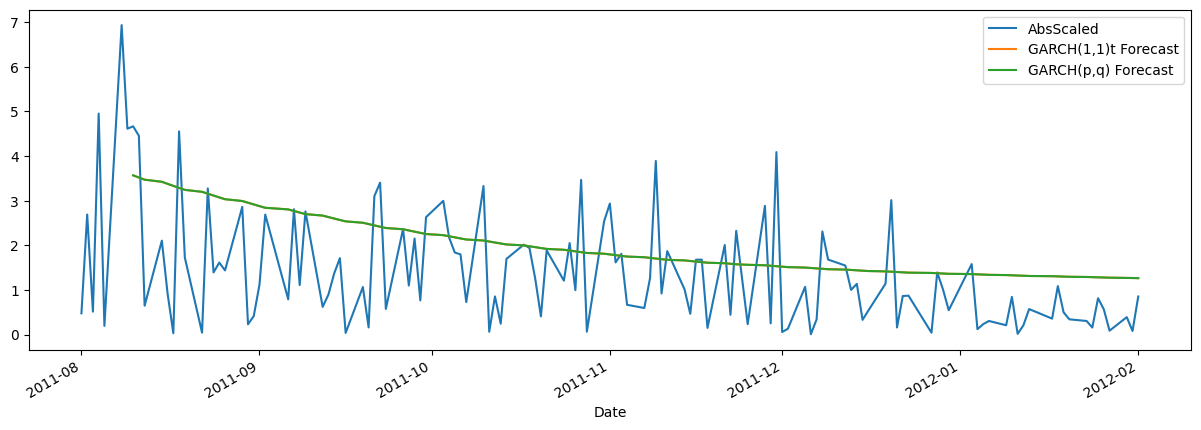

In [71]:
plot_cols = ['AbsScaled', 'GARCH(1,1)t Forecast', 'GARCH(p,q) Forecast']
df2.loc['2011-08-01':'2012-02-01'][plot_cols].plot(figsize=(15, 5));

In [72]:
train_idx = df2.index <= train.index[-1]
test_idx = ~train_idx

In [73]:
df2.loc[train_idx, 'GARCH(p,q) Train'] = res_garchpq.conditional_volatility
df2.loc[test_idx, 'GARCH(p,q) Test'] = np.sqrt(
    fcast_garchpq.variance.iloc[-1].to_numpy())

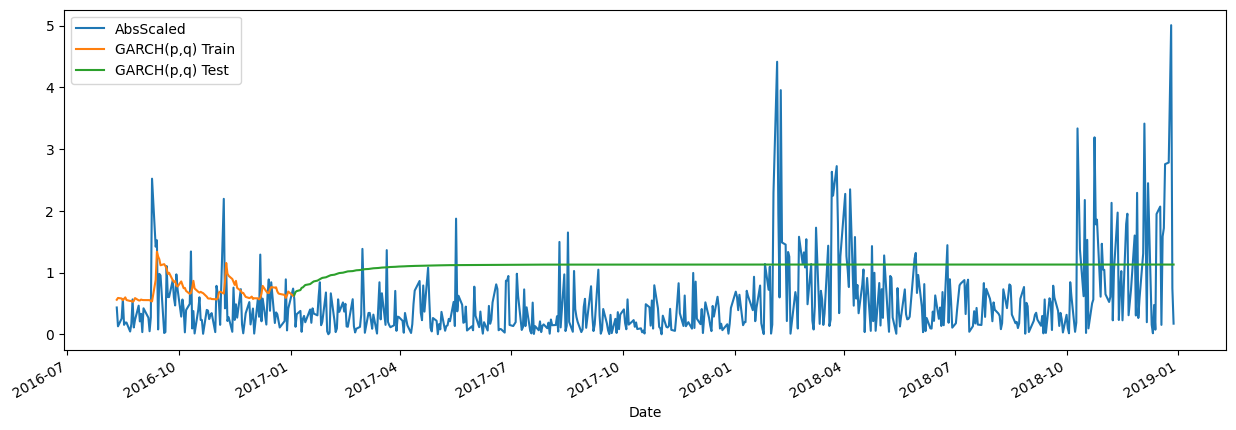

In [74]:
plot_cols = ['AbsScaled', 'GARCH(p,q) Train', 'GARCH(p,q) Test']
df2.iloc[-(Ntest+100):][plot_cols].plot(figsize=(15, 5));